# Problem Setting: Reversi.

<a name="h1_1"></a>

This notebook demonstrates a Multi-agent Q-Learning to solve Reversi. Reversi is a board game for two players, played on an $8 \times 8$ uncheckered board. First of all, the board must be generated. Here let's express it using `numpy.ndarray`.

In [1]:
import numpy as np
map_arr = np.zeros((8, 8)).astype(int)
map_arr[3, 3] = 1
map_arr[4, 4] = 1
map_arr[3, 4] = -1
map_arr[4, 3] = -1
map_arr

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

Even if you use `matplotlib` and `seaborn`, you can draw images similar to Reversi's board as it is.

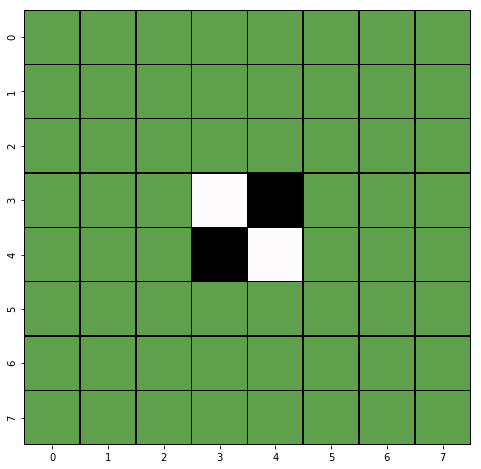

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
fig = plt.figure(figsize=(8, 8))
sns.heatmap(
    map_arr, 
    linewidths=.5, 
    cmap="gist_earth", 
    cbar=False, 
    linecolor="black"
)
plt.show()
plt.close()

In this matrix, `+1` means white and `-1` means black.

The players place their disks alternately and the agents observe the rewards corresponded to position of their disks. The relationship between the location of the disks and the rewards is defined by the following matrix.

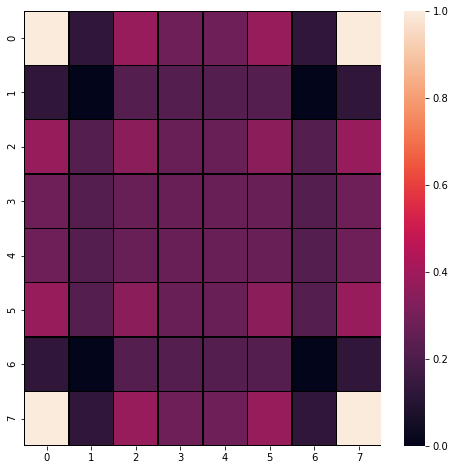

In [6]:
evaluate_map_arr = np.array([
    [120,-20, 20,  5,  5, 20,-20,120],
    [-20,-40, -5, -5, -5, -5,-40,-20],
    [ 20, -5, 15,  3,  3, 15, -5, 20],
    [  5, -5,  3,  3,  3,  3, -5,  5],
    [  5, -5,  3,  3,  3,  3, -5,  5],
    [ 20, -5, 15,  3,  3, 15, -5, 20],
    [-20,-40, -5, -5, -5, -5,-40,-20],
    [120,-20, 20,  5,  5, 20,-20,120]
])
evaluate_map_arr = (evaluate_map_arr - evaluate_map_arr.min()) / (evaluate_map_arr.max() - evaluate_map_arr.min())

fig = plt.figure(figsize=(8, 8))
sns.heatmap(
    evaluate_map_arr, 
    linewidths=.5, 
    linecolor="black"
)
plt.show()
plt.close()

I implemented `ReversiGreedyQLearning` by a rush. This class defines an agent's behavior in playing games. Although Reversi is two players game, a behavior of `ReversiGreedyQLearning` can be corresponded to one agent. Then you have to instantiate two objects of `ReversiGreedyQLearning`.

In [7]:
from devsample.reversi_greedy_q_learning import ReversiGreedyQLearning

white_player = ReversiGreedyQLearning(color=1)
black_player = ReversiGreedyQLearning(color=-1)

white_player.evaluate_map_arr = evaluate_map_arr
black_player.evaluate_map_arr = evaluate_map_arr

white_player.epsilon_greedy_rate = 0.8
black_player.epsilon_greedy_rate = 0.8

And then, I implemented `AlternatedMultiAgent` which is-a `MultiAgentQLearning`. This class is a template method to implement a controller for the Multi-Agent Q-Learning. `AlternatedMultiAgent` is a concrete class for an alternating learning, which can be described that each agent searchs optimal policy observing the enemy player's action. In other words, each agent's state can be transitioned to next state that corresponding to enemy player's action.

In [8]:
from pyqlearning.multiagentqlearning.alternated_multi_agent import AlternatedMultiAgent

multi_agent_q_learning = AlternatedMultiAgent(
    q_learning_list=[white_player, black_player]
)

multi_agent_q_learning.learn(first_state_key=map_arr.copy(), limit=80, game_n=300)

Let's visible the result of Multi-Agent learning.

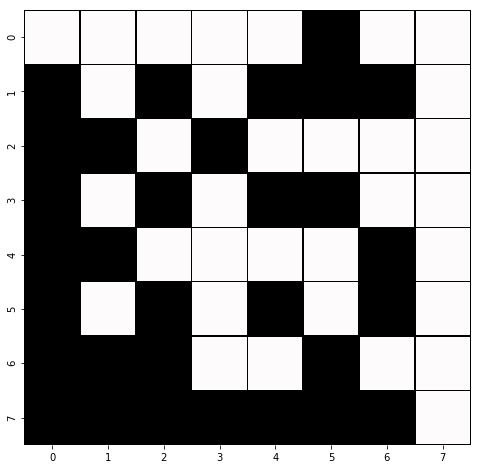

In [9]:
fig = plt.figure(figsize=(8, 8))
sns.heatmap(
    multi_agent_q_learning.state_key_list[-1], 
    linewidths=.5, 
    cmap="gist_earth", 
    cbar=False, 
    linecolor="black"
)
plt.show()
plt.close()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

for i in range(80):
    fig = plt.figure(figsize=(8, 8))
    sns.heatmap(
        multi_agent_q_learning.state_key_list[i], 
        linewidths=.5, 
        cmap="gist_earth", 
        cbar=False, 
        linecolor="black"
    )
    plt.savefig("/tmp/reversi_" + str(i) + ".png");plt.close()

first_img = Image.open("/tmp/reversi_0.png")
img_list = []
for i in range(1, 80):
    img = Image.open("/tmp/reversi_" + str(i) + ".png")
    img_list.append(img)
    
first_img.save(
    'reversi.gif', 
    save_all=True, 
    append_images=img_list,
    optimized=True, 
    duration=40, 
    loop=0
)

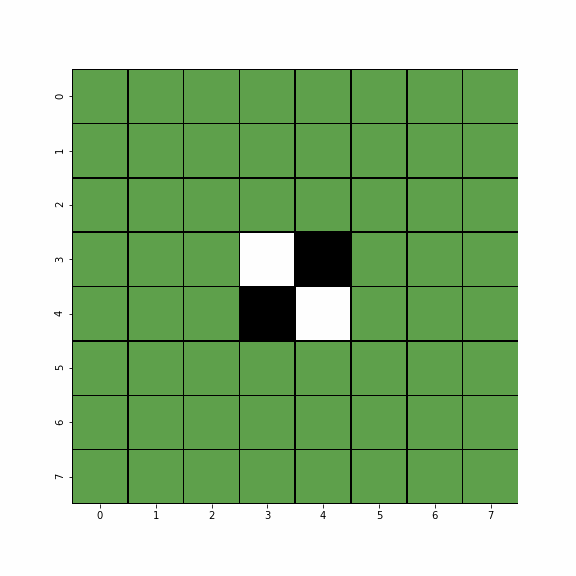

In [11]:
Image.open("reversi.gif")

By *transfer learning*, let's start the game again with different agents.

In [12]:
white_player_2 = ReversiGreedyQLearning(color=1)
black_player_2 = ReversiGreedyQLearning(color=-1)

white_player_2.epsilon_greedy_rate = 0.8
black_player_2.epsilon_greedy_rate = 0.8

# Transfer the parameters of policy tuned by pre-learning.
white_player_2.r_df = multi_agent_q_learning.q_learning_list[0].r_df
white_player_2.q_df = multi_agent_q_learning.q_learning_list[0].q_df
black_player_2.r_df = multi_agent_q_learning.q_learning_list[1].r_df
black_player_2.q_df = multi_agent_q_learning.q_learning_list[1].q_df

In [13]:
multi_agent_q_learning_2 = AlternatedMultiAgent(
    q_learning_list=[white_player_2, black_player_2]
)
multi_agent_q_learning_2.state_key_list = []
multi_agent_q_learning_2.learn(first_state_key=map_arr, limit=80, game_n=50)

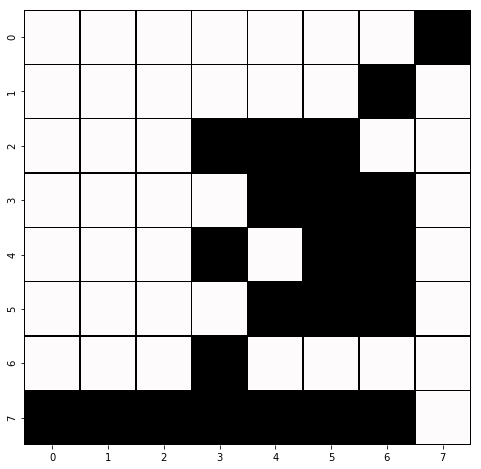

In [14]:
fig = plt.figure(figsize=(8, 8))
sns.heatmap(
    multi_agent_q_learning_2.state_key_list[-1], 
    linewidths=.5, 
    cmap="gist_earth", 
    cbar=False, 
    linecolor="black"
)
plt.show()
plt.close()

In [15]:
for i in range(80):
    fig = plt.figure(figsize=(8, 8))
    sns.heatmap(
        multi_agent_q_learning_2.state_key_list[i], 
        linewidths=.5, 
        cmap="gist_earth", 
        cbar=False, 
        linecolor="black"
    )
    plt.savefig("/tmp/reversi_t_" + str(i) + ".png");plt.close()

first_img = Image.open("/tmp/reversi_t_0.png")
img_list = []
for i in range(1, 80):
    img = Image.open("/tmp/reversi_t_" + str(i) + ".png")
    img_list.append(img)
    
first_img.save(
    'reversi_t.gif', 
    save_all=True, 
    append_images=img_list,
    optimized=True, 
    duration=40, 
    loop=0
)


In [ ]:
Image.open("reversi_t.gif")